In [1]:
import os
import astropy
import numpy as np
from astropy.table import Table
from astropy.table import Column
import glob
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sample_location = "/home/hallflower/sample/spectra/"
dash = "/mnt/c/users/20xha/Documents/Caltech/Research/DASH/"

In [3]:
SEDM_ML_sample = Table.read("/mnt/c/Users/20xha/Documents/Caltech/Research/SEDM_ML_sample.ascii", format = "ascii")
SEDM_ML_sample.rename_column('col1', 'ZTF_Name')
SEDM_ML_sample.rename_column('col2', "Class")
SEDM_ML_sample.rename_column('col8', "Version")

In [4]:
dashoutput = np.load(dash+"output.npy",allow_pickle=True)

In [5]:
snidoutput = np.load("/mnt/c/Users/20xha/Documents/Caltech/Research/SNID_results_rlap3.npy", allow_pickle=True)

In [6]:
final_rcf_table = Table.from_pandas(pd.read_hdf("/mnt/c/users/20xha/Documents/Caltech/Research/final_rcf_table.h5"))

In [7]:
ranges = np.linspace(0, 25, 6)
ResultsTable_List_rlap = []
count = 0

for i in ranges:
    ResultsTable = Table(
                    names=("ZTF_Name", "Closest"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "U64"
                          )
                    )
    for j in snidoutput:
        row = []
        row.append(j[0])
        if(np.max(j[1]["rlap"]) > i):
            row.append(j[1][0]["type"])
            ResultsTable.add_row(row)
    
    count += 1
    if(len(ResultsTable) != 0):
        ResultsTable_List_rlap.append([i,ResultsTable])
    if(count% 100 == 0):
        print(count)
ResultsTable_List_rlap = np.asarray(ResultsTable_List_rlap)

In [17]:
ResultsTable_List_confidence_rlap = []
ranges = np.linspace(0, 25, 6)
for rlap in ranges:
    count = 0
    ResultsTable = Table(
                    names=("ZTF_Name", "Dash", "Confidence",
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "U64", "float64",
                          )
                    )

    for i in dashoutput:
        row = []
        row.append(i[-1])
        reliable = np.where(np.asarray(i[4]) != 'Unreliable matches')[0]
        if(len(reliable) != 0):
            best = np.asarray(i[2])[:,0][reliable]
            c = Counter(best)
            rlap_list = []
            for rlap_vals in np.asarray(i[3]):
                rlap_list.append(float(rlap_vals.split(":")[-1]))
            best_rlap = np.max(rlap_list)
            if(best_rlap > rlap):
                row.append(c.most_common()[0][0])
                row.append(best_rlap)
                ResultsTable.add_row(row)

        count += 1
    if(count % 50 == 0):
        print(count)
            
    if(len(ResultsTable) != 0):
        ResultsTable_List_confidence_rlap.append([rlap,ResultsTable])

In [8]:
negativeII = 0
positiveII = 0
for j in final_rcf_table:
    correct_1a = "II" in j["sn_type"]
    if(correct_1a):
        positiveII += 1
    if(not(correct_1a)):
        negativeII += 1

In [9]:
counters_rlap_1a_II = [] 
for i in ResultsTable_List_rlap:
    truepositiveII = 0
    falsepositiveII = 0
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    for j in JoinedResults:
        correct_1a = "II" in j["sn_type"]
        classified_1a = "II" in j["Closest"]
        if(correct_1a == True and classified_1a == True):
            truepositiveII += 1
        if(correct_1a != True and classified_1a == True):
            falsepositiveII += 1
    counters_rlap_1a_II.append([i[0],truepositiveII/(positiveII),falsepositiveII/(negativeII),len(JoinedResults), truepositiveII, falsepositiveII])
counters_rlap_1a_II = np.asarray(counters_rlap_1a_II)

In [20]:
counters_confidence_1a_rlap = [] 
for i in ResultsTable_List_confidence_rlap:
    truepositive = 0
    falsepositive = 0
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    
    for j in JoinedResults:
        correct_1a = "II" in j["sn_type"]
        classified_1a = "II" in j["Dash"]
        if(correct_1a == True and classified_1a == True):
            truepositive += 1
        if(correct_1a != True and classified_1a == True):
            falsepositive += 1
    counters_confidence_1a_rlap.append([i[0],truepositive/(positiveII),falsepositive/(negativeII),len(JoinedResults), truepositive, falsepositive])
counters_confidence_1a_rlap = np.asarray(counters_confidence_1a_rlap)

Text(0, 0.5, 'True Positive Rate')

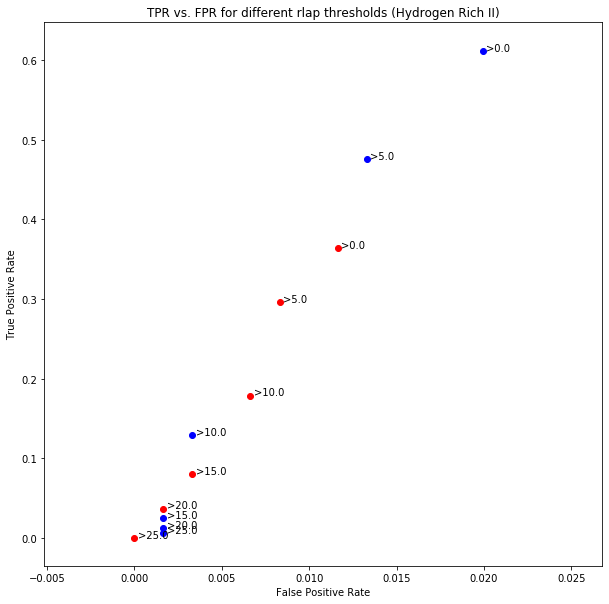

In [22]:
fig = plt.figure(figsize = (10,10))
plt.scatter(counters_rlap_1a_II[:,2], counters_rlap_1a_II[:,1], color = "blue")
plt.scatter(counters_confidence_1a_rlap[:,2], counters_confidence_1a_rlap[:,1], color = "red")
for i in counters_rlap_1a_II:
    plt.text(i[2]+.0002,i[1]+.0002,">"+str(i[0]))
for i in counters_confidence_1a_rlap:
    plt.text(i[2]+.0002,i[1]+.0002,">"+str(i[0]))
plt.title("TPR vs. FPR for different rlap thresholds (Hydrogen Rich II)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [11]:
negativeIbIc = 0
positiveIbIc = 0
for j in final_rcf_table:
    correct_1a = ("Ib" in j["sn_type"]) or ("Ic" in j["sn_type"]) 
    if(correct_1a):
        positiveIbIc += 1
    if(not(correct_1a)):
        negativeIbIc += 1

In [12]:
counters_rlap_1a_IbIc = [] 
for i in ResultsTable_List_rlap:
    truepositiveIbIc = 0
    falsepositiveIbIc = 0
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    for j in JoinedResults:
        correct_1a = ("Ib" in j["sn_type"])
        classified_1a = ("Ib" in j["Closest"])
        if(correct_1a == True and classified_1a == True):
            truepositiveIbIc += 1
        if(correct_1a != True and classified_1a == True):
            falsepositiveIbIc += 1
            
        correct_1a = ("Ic" in j["sn_type"])
        classified_1a = ("Ic" in j["Closest"])
        if(correct_1a == True and classified_1a == True):
            truepositiveIbIc += 1
        if(correct_1a != True and classified_1a == True):
            falsepositiveIbIc += 1
        
    counters_rlap_1a_IbIc.append([i[0],truepositiveIbIc/(positiveIbIc),falsepositiveIbIc/(negativeIbIc),len(JoinedResults), truepositiveIbIc, falsepositiveIbIc])
counters_rlap_1a_IbIc = np.asarray(counters_rlap_1a_IbIc)

In [28]:
counters_confidence_rlap_IbIc = [] 
for i in ResultsTable_List_confidence_rlap:
    truepositiveIbIc = 0
    falsepositiveIbIc = 0
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    
    for j in JoinedResults:
        correct_1a = ("Ib" in j["sn_type"])
        classified_1a = ("Ib" in j["Dash"])
        if(correct_1a == True and classified_1a == True):
            truepositiveIbIc += 1
        if(correct_1a != True and classified_1a == True):
            falsepositiveIbIc += 1
            
        correct_1a = ("Ic" in j["sn_type"])
        classified_1a = ("Ic" in j["Dash"])
        if(correct_1a == True and classified_1a == True):
            truepositiveIbIc += 1
        if(correct_1a != True and classified_1a == True):
            falsepositiveIbIc += 1
    counters_confidence_rlap_IbIc.append([i[0],truepositiveIbIc/(positiveIbIc),falsepositiveIbIc/(negativeIbIc),len(JoinedResults), truepositiveIbIc, falsepositiveIbIc])
counters_confidence_rlap_IbIc = np.asarray(counters_confidence_rlap_IbIc)

Text(0, 0.5, 'True Positive Rate')

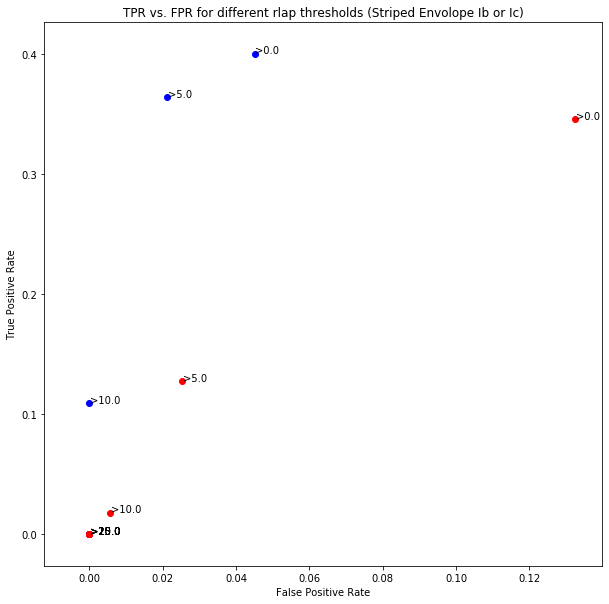

In [29]:
fig = plt.figure(figsize = (10,10))
plt.scatter(counters_rlap_1a_IbIc[:,2], counters_rlap_1a_IbIc[:,1], color = "blue")
plt.scatter(counters_confidence_rlap_IbIc[:,2], counters_confidence_rlap_IbIc[:,1], color = "red")
for i in counters_rlap_1a_IbIc:
    plt.text(i[2]+.0002,i[1]+.0002,">"+str(i[0]))
for i in counters_confidence_rlap_IbIc:
    plt.text(i[2]+.0002,i[1]+.0002,">"+str(i[0]))
plt.title("TPR vs. FPR for different rlap thresholds (Striped Envolope Ib or Ic)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [14]:
counters_rlap_1a_IbIc

array([[0.00000000e+00, 4.00000000e-01, 4.51339915e-02, 6.14000000e+02,
        2.20000000e+01, 3.20000000e+01],
       [5.00000000e+00, 3.63636364e-01, 2.11565585e-02, 5.58000000e+02,
        2.00000000e+01, 1.50000000e+01],
       [1.00000000e+01, 1.09090909e-01, 0.00000000e+00, 3.09000000e+02,
        6.00000000e+00, 0.00000000e+00],
       [1.50000000e+01, 0.00000000e+00, 0.00000000e+00, 1.37000000e+02,
        0.00000000e+00, 0.00000000e+00],
       [2.00000000e+01, 0.00000000e+00, 0.00000000e+00, 5.40000000e+01,
        0.00000000e+00, 0.00000000e+00],
       [2.50000000e+01, 0.00000000e+00, 0.00000000e+00, 1.80000000e+01,
        0.00000000e+00, 0.00000000e+00]])

In [15]:
dashoutput[0]

array([array([[['', 'Ia-91bg', '6 to 10', '0.99907947'],
        ['', 'IIP', '6 to 10', '0.0009203481'],
        ['', 'Ia-csm', '46 to 50', '1.4276151e-07'],
        ['', 'IIP', '2 to 6', '8.413739e-15'],
        ['', 'IIn', '-14 to -10', '1.5309002e-15'],
        ['', 'Ibn', '42 to 46', '7.0210065e-18'],
        ['', 'Ia-norm', '14 to 18', '6.4561103e-22'],
        ['', 'Ia-91bg', '10 to 14', '1.2169977e-22'],
        ['', 'IIn', '42 to 46', '2.0284145e-23'],
        ['', 'Ic-broad', '6 to 10', '4.7064436e-24'],
        ['', 'Ia-91bg', '26 to 30', '4.523396e-25'],
        ['', 'IIP', '14 to 18', '2.228336e-25'],
        ['', 'IIP', '10 to 14', '7.719748e-26'],
        ['', 'Ia-norm', '30 to 34', '1.1194561e-26'],
        ['', 'Ia-91bg', '18 to 22', '3.287164e-27']],

       [['', 'Ia-91bg', '6 to 10', '0.99912125'],
        ['', 'IIP', '6 to 10', '0.000878735'],
        ['', 'Ia-csm', '46 to 50', '2.7898492e-08'],
        ['', 'IIn', '-14 to -10', '6.241117e-16'],
        ['', 'IIP', 